In [ ]:
# installing kaggle library
! pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle
#!chmod 600 ~/.kaggle/kaggle.json
!cp /content/'kaggle.json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API for fetching data to Kaggle :
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
100% 491M/493M [00:23<00:00, 20.9MB/s]
100% 493M/493M [00:23<00:00, 21.9MB/s]


In [ ]:
#Unzip data
from zipfile import ZipFile
Amazonedata = '/content/amazonreviews.zip'
with ZipFile(Amazonedata, 'r') as zip:
  zip.extractall()
  print('Amazone data has been extracted')

Amazone data has been extracted


In [ ]:
# Installing all dependency :
import numpy as np
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.layers import LSTM, Bidirectional, Dropout
from keras.optimizers import Adam
import keras.backend as K


In [ ]:
#Downloading stopwords data
nltk.download('stopwords')
# Load English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Spanish stopwords
spanish_stopwords = set(stopwords.words('spanish'))

# Combine both sets of stopwords
combined_stopwords = english_stopwords.union(spanish_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#print stopwords for both englisha nd spanish
print(stopwords.words('english'))
print(stopwords.words('spanish'))
print(combined_stopwords)



['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#Pre processing data, creating dataframe
import bz2
# Specify the path to the compressed file
compressed_file_path = '/content/train.ft.txt.bz2'

# Decompress the file and read its content
with bz2.open(compressed_file_path, 'rt', encoding='ISO-8859-1') as f:
    lines = f.readlines()

# Parse the lines and create a list of dictionaries
data = []
for line in lines:
    parts = line.strip().split(' ', 1)  # Split into label and text, with a maximum of 1 split
    label = parts[0].replace('__label__', '')  # Remove the prefix '__label__'
    text = parts[1]
    data.append({'label': label, 'text': text})

# Create a DataFrame from the list of dictionaries
Amazone = pd.DataFrame(data)

# Display the DataFrame
print(Amazone.head())


  label                                               text
0     2  Stuning even for the non-gamer: This sound tra...
1     2  The best soundtrack ever to anything.: I'm rea...
2     2  Amazing!: This soundtrack is my favorite music...
3     2  Excellent Soundtrack: I truly like this soundt...
4     2  Remember, Pull Your Jaw Off The Floor After He...


In [ ]:
Amazone_train = Amazone.head(150000)
print(Amazone_train.shape)

(150000, 2)


In [ ]:
# Convert label values from strings to integers and subtract 1
Amazone_train['label'] = Amazone_train['label'].astype(int) - 1

# Update the 'label' column in the DataFrame with the modified values
Amazone_train['label'] = Amazone_train['label'].values


<ipython-input-13-0bedcb911527>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train['label'] = Amazone_train['label'].astype(int) - 1
<ipython-input-13-0bedcb911527>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train['label'] = Amazone_train['label'].values


In [ ]:
#Check for Null value
Amazone_train.isnull().sum()


label    0
text     0
dtype: int64

In [ ]:
# Checking for balance of data
Amazone_train['label'].value_counts()

label
1    76248
0    73752
Name: count, dtype: int64

In [ ]:
# Reading contractions.csv and storing it as a dict for data processing
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [ ]:
import re
# function for data processing
def stemming(text,english_stopwords ):
    # Define regex patterns for preprocessing
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-z0-9<>]"
    smileemoji = r"[8:=;]['`\-]?[)d]+"
    sademoji = r"[8:=;]['`\-]?\(+"
    neutralemoji = r"[8:=;]['`\-]?[\/|l*]"
    lolemoji = r"[8:=;]['`\-]?p+"

    # Preprocess text
    text = text.lower()
    text = re.sub(urlPattern, '<url>', text)
    text = re.sub(userPattern, '<user>', text)
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smileemoji, '<smile>', text)
    text = re.sub(sademoji, '<sadface>', text)
    text = re.sub(neutralemoji, '<neutralface>', text)
    text = re.sub(lolemoji, '<lolface>', text)

    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)

    text = re.sub(alphaPattern, ' ', text)
    text = re.sub(r'/', ' / ', text)

    # Perform stemming
    stemmed_text = re.sub('[^a-zA-Z]', ' ', text)
    stemmed_text = stemmed_text.lower().split()
    stemmed_text = [word for word in stemmed_text if word not in english_stopwords]
    stemmed_text = ' '.join(stemmed_text)

    return stemmed_text


In [ ]:
# Applying fucntion to text data aka Amazone reviews
Amazone_train['stemmed_text'] = Amazone_train['text'].apply(stemming, english_stopwords=combined_stopwords)


<ipython-input-17-752a03d9bf6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train['stemmed_text'] = Amazone_train['text'].apply(stemming, english_stopwords=combined_stopwords)


In [ ]:
# how data look loke after cleaning
Amazone_train.head()

,label,text,stemmed_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even non gamer sound track beautiful p...
1,1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything reading lot revi...
2,1,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...


In [ ]:
# function for both stemming and lemmaziration
import spacy
#import re

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Disabling unneeded components for efficiency
nlp.disable_pipes('ner', 'parser')  # Only tokenization and lemmatization are needed

def clean_and_lemmatize(texts):
    # Preprocess and clean text outside the pipeline for better performance
    cleaned_texts = (re.sub('[^a-zA-Z]', ' ', text).lower() for text in texts)

    # Process texts as a stream using nlp.pipe for efficient batch processing
    for doc in nlp.pipe(cleaned_texts, batch_size=1000):
        # Filter out stopwords and non-alpha tokens, then lemmatize
        lemmatized_text = ' '.join(token.lemma_ for token in doc if not token.is_stop and token.is_alpha)
        yield lemmatized_text


In [ ]:
# Adding columns to dataframe  after lemmelization
Amazone_train['stemmed_text_2'] = list(clean_and_lemmatize(Amazone_train['text']))

<ipython-input-24-cb4e0c6999bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train['stemmed_text_2'] = list(clean_and_lemmatize(Amazone_train['text']))


In [ ]:
print(Amazone_train['stemmed_text'])

0         stuning even non gamer sound track beautiful p...
1         best soundtrack ever anything reading lot revi...
2         amazing soundtrack favorite music time hands i...
3         excellent soundtrack truly like soundtrack enj...
4         remember pull jaw floor hearing played game kn...
                                ...                        
199995    lanterns lit world book exciting look graphics...
199996    antique lantern guide learning subject gave ex...
199997    great old school gundam fans gundam battle ass...
199998    great game great game characters pilots choose...
199999    great game game love much fun always play gund...
Name: stemmed_text, Length: 200000, dtype: object


After trying on both 2 techniques,choose to use data after stemming only

In [ ]:
#Amazone_train.drop(['text', 'stemmed_text_2'], axis=1, inplace=True)

<ipython-input-30-7b97b1b53c57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Amazone_train.drop(['text', 'stemmed_text'], axis=1, inplace=True)


In [ ]:
# Seperating data and lable for both training and testing data
X = Amazone_train['stemmed_text'].values
Y = Amazone_train['label'].values

In [ ]:
#Split the Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32, stratify=Y)

In [ ]:
print(X_train)
print(Y_train)

['cracks showing slagging pogues something like going true bands like means take criticism well accolades fact album misses mark far band might even star affair pogues spider stacy claimed timid raucous hogwash songwriting uninteresting conviction band especially shaneis vocals found wanting album never really gels pogues release matt johnsonis subsequent thethe releases following infected similar total departure might saluted artistic read maturity change less interesting result find used cheap might want pick otherwise forget sure pogues already'
 'two hours never get back heard remaking haunting excited love original movie thought modern techniques could make good movie better wrong sitting stinker torture one worst movies ever seen thing thatis similar shirley jacksonis novel original movie name want something fun go get root canal would lot fun movie'
 'took forever arrive took couple months receive order seems ran stock real hurry replenish offered refund really wanted smoker hen

Data visualization

['kaufmann', 'lives', 'name', 'selections', 'excellent', 'book', 'ruined', 'kaufmannis', 'philistine', 'misunderstanding', 'sartre', 'nietzsche', 'especially', 'kierkegaard', 'last', 'point', 'see', 'previous', 'reviewers', 'details', 'wkis', 'ludicrous', 'misunderstanding', 'read', 'authors', 'included', 'available', 'affordable', 'english', 'translations', 'apart', 'atrociously', 'edited', 'anthology', 'descriptive', 'fascinating', 'read', 'really', 'enjoyed', 'book', 'saw', 'special', 'lillian', 'helllman', 'pbs', 'purchased', 'book', 'led', 'fascinating', 'life']


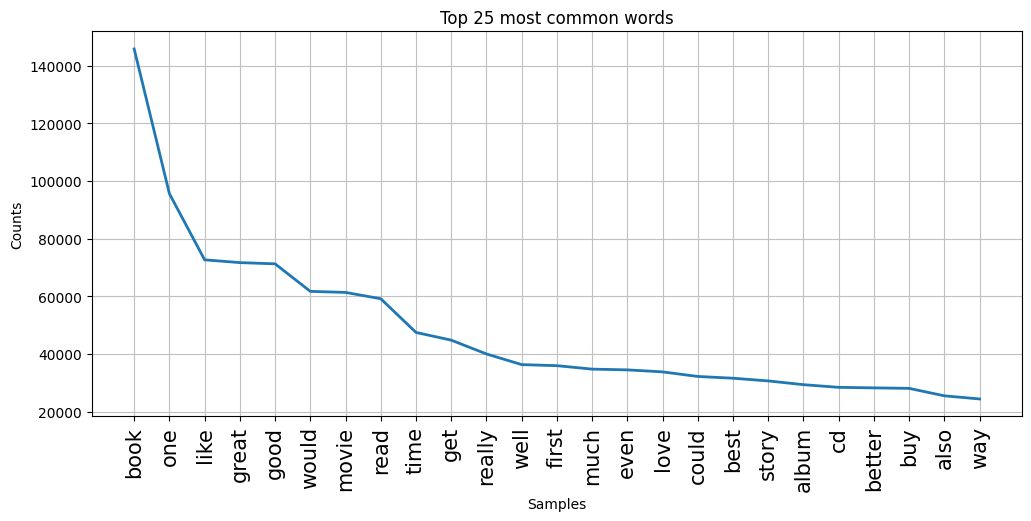

In [ ]:

from nltk.probability import FreqDist
all_words = []
for text in X_train:
    all_words.extend(text.split())

print(all_words[:50])

# Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()

### Machine learning model


In [ ]:
# Converting textual data to numerical data using TflidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_ML = TfidfVectorizer(ngram_range=(1, 1))# preferable because it captured the word inportance more than one-hot encoding
X_train_ML = vectorizer_ML.fit_transform(X_train)

In [ ]:
print(X_train_ML[1])

  (0, 70793)	0.10541234103352753
  (0, 133953)	0.06796041588811169
  (0, 17480)	0.2299903160643004
  (0, 102424)	0.2098819232861664
  (0, 49639)	0.09829971995811027
  (0, 47056)	0.22854225307322715
  (0, 80237)	0.13292193614590123
  (0, 82737)	0.11928834713950402
  (0, 62760)	0.2252008353387793
  (0, 107855)	0.21267231873887435
  (0, 119736)	0.11889002604277496
  (0, 120497)	0.10243471741682321
  (0, 106081)	0.11209122459600158
  (0, 40450)	0.09112153988183974
  (0, 79005)	0.11255301810376557
  (0, 133891)	0.1160007653312415
  (0, 84415)	0.05817392002059913
  (0, 122416)	0.19609881653925973
  (0, 114367)	0.21113308429334238
  (0, 109266)	0.1634315817700476
  (0, 134200)	0.12045989448070066
  (0, 11684)	0.08576658519533437
  (0, 49980)	0.06516093314487482
  (0, 72384)	0.09220942303308143
  (0, 26266)	0.0822569866772553
  (0, 118800)	0.17944142873995464
  (0, 77646)	0.14676134630660753
  (0, 120790)	0.10071654659372349
  (0, 78961)	0.3104258853323091
  (0, 85214)	0.23044821301252139
  (0

In [ ]:
X_test_ML = vectorizer_ML.transform(X_test)

In [ ]:
print(X_test_ML)

  (0, 134794)	0.15636337561293162
  (0, 129826)	0.18520032267631803
  (0, 120524)	0.1296902038492008
  (0, 118885)	0.26222984320506443
  (0, 102677)	0.2641282903679592
  (0, 95409)	0.14774903349496576
  (0, 90769)	0.1700805904402719
  (0, 78247)	0.25378415982841673
  (0, 74047)	0.33985732866659657
  (0, 70905)	0.12101003581847189
  (0, 57811)	0.46328640970225343
  (0, 50916)	0.09556937044911962
  (0, 49980)	0.09453367674613404
  (0, 47038)	0.24356955595404395
  (0, 21045)	0.19553653864694148
  (0, 18999)	0.28122184899822067
  (0, 10472)	0.36227436064834484
  (1, 134815)	0.05547978071475605
  (1, 133953)	0.03927265860062026
  (1, 128313)	0.09179634221413992
  (1, 124847)	0.07876862008752639
  (1, 124769)	0.05453962069543078
  (1, 124487)	0.07748055653699559
  (1, 122211)	0.21107661514190995
  (1, 121384)	0.04236488766107205
  :	:
  (59999, 52097)	0.06847235380895365
  (59999, 50916)	0.033384691720080586
  (59999, 50714)	0.09521924222649443
  (59999, 49980)	0.033022898869210955
  (59999,

In [ ]:
# Training the LogisticRegression model :
model_logistic = LogisticRegression(max_iter=100)
model_logistic.fit(X_train_ML, Y_train)

LogisticRegression()

In [ ]:
# accuracy score on training data :
X_train_pred = model_logistic.predict(X_train_ML)
training_acc = accuracy_score(Y_train, X_train_pred)

In [ ]:
print('Training data accuracy score:', training_acc)

Training data accuracy score: 0.9164083333333334


In [ ]:
#accuracy on testing data:
X_test_pred = model_logistic.predict(X_test_ML)
testing_acc = accuracy_score(Y_test, X_test_pred)


In [ ]:
print('Testing data accuracy score:', testing_acc)

Testing data accuracy score: 0.8891666666666667


In [ ]:
# Test 1 output form test data:
X_test_1 = X_test_ML[145]
print(X_test_1)
pred_1 = model_logistic.predict(X_test_1)
if (pred_1[0] == 1):
  print('This is negative review with rating from 1 to 2 stars')
else:
  print('This is positive review with rating from 4 to 5 stars')


  (0, 116316)	0.1123266160366012
  (0, 116155)	0.19990520672119255
  (0, 94335)	0.5050945937860107
  (0, 85449)	0.1614506030926427
  (0, 85428)	0.10761653870854397
  (0, 79206)	0.26477053266267014
  (0, 78132)	0.1733773142697955
  (0, 76791)	0.06338621543390471
  (0, 71580)	0.5074855529427765
  (0, 66419)	0.09918917204171818
  (0, 62608)	0.1293453013692696
  (0, 13376)	0.15999625856237892
  (0, 7029)	0.4906754996206185
This is positive review with rating from 4 to 5 stars


After performing the simpler machine learning tasks on Amazone sentiment analysis , we continue with the RNN models, Before buiding model with suitable model architecture ,we need to aplply more of the data processing techniques such as words embedding using pre_trained GLOVE model

### CNN model:

In [ ]:
# Setting parameters
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 30


In [ ]:
# Download the pre_trained Glove model 100 texts for word embedding
import os
# Define the URL and the target directory for GloVe vectors
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_target_dir = '../large_files/glove.6B'

# Create the directory if it doesn't exist
os.makedirs(glove_target_dir, exist_ok=True)

# Download the GloVe ZIP file
os.system(f'wget {glove_url} -P {glove_target_dir}')

# Unzip the file
os.system(f'unzip {glove_target_dir}/glove.6B.zip -d {glove_target_dir}')

2304

In [ ]:
# Tokenize texts
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(filters="", lower=False)#, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = MAX_VOCAB_SIZE

In [ ]:
## Tokenization and padding :

# Create a new word index with only the top MAX_VOCAB_SIZE words
word_index = tokenizer.word_index
top_word_index = {word: index for word, index in word_index.items() if index <= MAX_VOCAB_SIZE}

# Update the tokenizer's word index
tokenizer.word_index = top_word_index
tokenizer.num_words = MAX_VOCAB_SIZE

# Tokenize sequences
tokenized_train_sequences = tokenizer.texts_to_sequences(X_train)
tokenized_test_sequences = tokenizer.texts_to_sequences(X_test)

# Print tokenized sequences before padding
print("Tokenized Sequences (Before Padding):")
for i, seq in enumerate(tokenized_train_sequences[:5], 1):
    print(f"Sample {i}: {seq}")

# Pad sequences
X_train = pad_sequences(tokenized_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(tokenized_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Print shapes and some details
print("X_train_padded.shape:", X_train.shape)
print("X_test_padded.shape:", X_test.shape)
print("Tokenizer vocab length:", len(tokenizer.word_index))



Tokenized Sequences (Before Padding):
Sample 1: [1642, 17, 911, 633, 315, 134, 592, 72, 21, 995, 27, 956, 592]
Sample 2: [171, 1, 11, 3307, 483, 197, 118, 16, 319, 1296, 71, 1015, 1080, 38, 422, 334, 121, 546, 257, 159, 436, 154, 898, 1803, 146, 65, 586, 653, 1547, 807, 168, 37, 1823, 4183, 62, 2, 293, 11, 225, 3140, 60, 2553, 1536, 71, 1, 444, 21, 483, 1033, 72, 25, 141, 225, 2132, 3328, 53, 187, 199, 109, 10, 1006]
Sample 3: [746, 746, 566, 145, 215, 189, 1743, 29, 46, 6, 572, 49, 746, 1048, 985, 1214, 312, 980, 1975, 1803, 985, 417, 603, 54, 985]
Sample 4: [378, 345, 3524, 684, 33, 550, 46, 597, 652, 78, 3511, 597, 2398, 652, 78, 1965, 3420, 3511, 597, 16, 1906, 460, 652, 78, 2230, 1499, 652, 78, 8483, 4208, 2506, 2913, 652, 1089, 4208, 5079, 361, 127, 4, 4498, 508, 652, 90, 685]
Sample 5: [19, 255, 276, 32, 449, 4883, 23, 112, 69, 4087, 2296, 6211, 1425, 9665, 430, 88, 335, 6547, 1466, 1044, 26, 631, 1590, 5621, 235, 24, 51, 26, 20, 1083, 192]
X_train_padded.shape: (120000, 100)
X_

In [ ]:
print("Tokenized and Padded Text in X_train:")
for i in range(1):  # Print the first 5 samples
    print("Sample", i+1, ":", X_train[i])

Tokenized and Padded Text in X_train:
Sample 1 : [1642   17  911  633  315  134  592   72   21  995   27  956  592    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
print("max sequence length:", max(len(s) for s in tokenized_train_sequences ))
print("min sequence length:", min(len(s) for s in tokenized_train_sequences ))
s = sorted(len(s) for s in tokenized_train_sequences )
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in tokenized_train_sequences  if len(seq) > 0))


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

max sequence length: 118
min sequence length: 0
median sequence length: 33
max word index: 9999
Found 10000 unique tokens.


In [ ]:
# locating the glove model:
# Define the directory where you saved the GloVe file
glove_directory = "../large_files/glove.6B"

# List the contents of the directory
contents = os.listdir(glove_directory)

# Print the contents to find the GloVe file name
print(contents)


['glove.6B.50d.txt', 'glove.6B.300d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.zip']


In [ ]:
from gensim.models import KeyedVectors

# Path to the downloaded GloVe file
glove_file = "/large_files/glove.6B/glove.6B.100d.txt"


# Load GloVe embeddings into memory
word2vec = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)



In [ ]:
# Word_embedding using Glove
word2idx = tokenizer.word_index
# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word2idx) + 1, 100))  # Adjust embedding dimension as per GloVe vectors (100d)

# Populate embedding matrix with GloVe word vectors
for word, i in word2idx.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

# Use embedding matrix to perform word embedding on X_train_padded and X_test_padded
embedded_X_train = np.array([embedding_matrix[word] for word in X_train_padded])
embedded_X_test = np.array([embedding_matrix[word] for word in X_test_padded])

In [ ]:
# Check the length of word2idx (vocabulary size)
vocabulary_size = len(word2idx)
# Check the dimensions of the embedding matrix
embedding_matrix_shape = embedding_matrix.shape
# Compare the vocabulary size with the embedding matrix shape
if vocabulary_size != embedding_matrix_shape[0]:
    print("Mismatch between vocabulary size and embedding matrix dimensions.")
    print("Vocabulary size:", vocabulary_size)
    print("Embedding matrix shape:", embedding_matrix_shape)
else:
    print("Vocabulary size matches embedding matrix dimensions.")


Mismatch between vocabulary size and embedding matrix dimensions.
Vocabulary size: 10000
Embedding matrix shape: (10001, 100)


In [ ]:
# Checking for vocabulary coverage using that pre trained gove model of 100 common words
# Get the set of words in the GloVe vocabulary
glove_vocab = set(word2vec.index_to_key)

# Get the set of words in your dataset's vocabulary
dataset_vocab = set(word2idx.keys())

# Calculate the intersection of the two vocabularies (words in both)
intersection = glove_vocab.intersection(dataset_vocab)

# Calculate the coverage percentage
coverage_percentage = len(intersection) / len(dataset_vocab) * 100

print("Vocabulary Coverage: {:.2f}%".format(coverage_percentage))

Vocabulary Coverage: 98.31%


In [ ]:
#Creating fucntion For out of vocabulary words,fill in vectirs with similar words
def find_similar_word(word, model, topn=1):
    try:
        similar_words = model.most_similar(word, topn=topn)
        return similar_words[0][0]  # Return the most similar word
    except KeyError:
        return None  # Return None if word not found in vocabulary

In [ ]:
def fill_with_similar_words(word2idx, word2vec_model, embedding_dim):
    num_words = len(word2idx) # Increment the vocabulary size by 1 to account for the padding index
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word2idx.items():
        if i < num_words:  # Check if the index is within bounds
            embedding_vector = word2vec_model[word] if word in word2vec_model else None
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                similar_word = find_similar_word(word, word2vec_model)
                if similar_word is not None:
                    embedding_matrix[i] = word2vec_model[similar_word]
    return embedding_matrix


In [ ]:
# Apply the fill_with_similar_words function to generate embedding matrices
embedding_matrix_train = fill_with_similar_words(word2idx, word2vec, EMBEDDING_DIM)
embedding_matrix_test = fill_with_similar_words(word2idx, word2vec, EMBEDDING_DIM)

In [ ]:
#Checking the shape after word embedding
print(embedding_matrix_train.shape)


(10000, 100)


In [ ]:
# Define Embedding layer for models
embedding_layer = Embedding(
  min(MAX_VOCAB_SIZE, len(word2idx)),
  EMBEDDING_DIM,
  weights=[embedding_matrix_train],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


Buidling CNN model

In [ ]:
from keras.models import Sequential
def getModel_cnn():
    model = Sequential([
        embedding_layer,
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model_CNN")
    return model

In [ ]:
training_model = getModel_cnn()
training_model.summary()

Model: "Sentiment_Model_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 48, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 46, 64)            24640     
                                                                 
 global_max_pooling1d_8 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_23 (Dense)            (None, 32)        

In [ ]:
# Compiling the model
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training CNN model
print('Training CNN model...')
r1=training_model.fit(
  X_train, Y_train,
  batch_size = 32,
  epochs=30,
  validation_split=0.2
)

Training CNN model...
Epoch 1/30
3000/3000 [==============================] - 14s 4ms/step - loss: 0.4004 - accuracy: 0.8142 - val_loss: 0.3723 - val_accuracy: 0.8342
Epoch 2/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.3271 - accuracy: 0.8586 - val_loss: 0.3440 - val_accuracy: 0.8504
Epoch 3/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.2862 - accuracy: 0.8777 - val_loss: 0.3365 - val_accuracy: 0.8542
Epoch 4/30
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2502 - accuracy: 0.8957 - val_loss: 0.3328 - val_accuracy: 0.8574
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.2166 - accuracy: 0.9108 - val_loss: 0.3483 - val_accuracy: 0.8531
Epoch 6/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.1824 - accuracy: 0.9264 - val_loss: 0.3923 - val_accuracy: 0.8507
Epoch 7/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.1536 - accuracy: 0.9401 - val

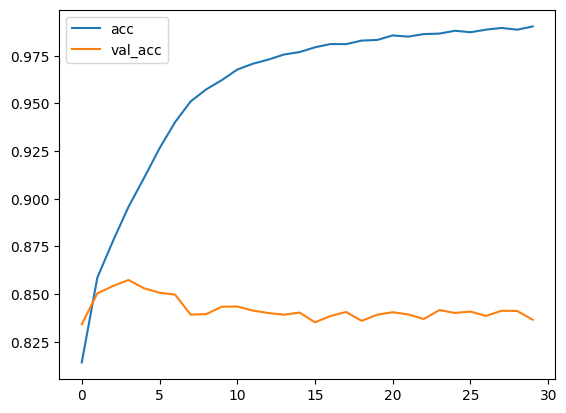

In [ ]:
# Ploting CNN model in terms of accuracy
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# Sentiment analysis using CNN version 2 with different architecture:
print('Building CNN model...')
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)



Building CNN model...


In [ ]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
print('Training model...')
r = model.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/30
3000/3000 [==============================] - 16s 5ms/step - loss: 0.4034 - accuracy: 0.8144 - val_loss: 0.5303 - val_accuracy: 0.7830
Epoch 2/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.3221 - accuracy: 0.8622 - val_loss: 0.3301 - val_accuracy: 0.8623
Epoch 3/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2901 - accuracy: 0.8782 - val_loss: 0.3267 - val_accuracy: 0.8642
Epoch 4/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2603 - accuracy: 0.8926 - val_loss: 0.3187 - val_accuracy: 0.8669
Epoch 5/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2377 - accuracy: 0.9039 - val_loss: 0.3499 - val_accuracy: 0.8605
Epoch 6/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.2158 - accuracy: 0.9150 - val_loss: 0.3340 - val_accuracy: 0.8655
Epoch 7/30
3000/3000 [==============================] - 14s 5ms/step - loss: 0.1937 - accuracy: 0.9241 - val_los

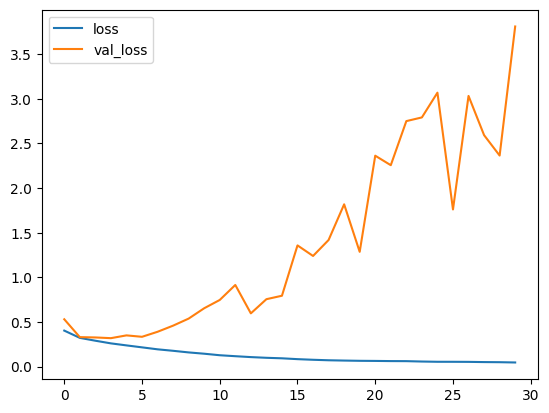

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

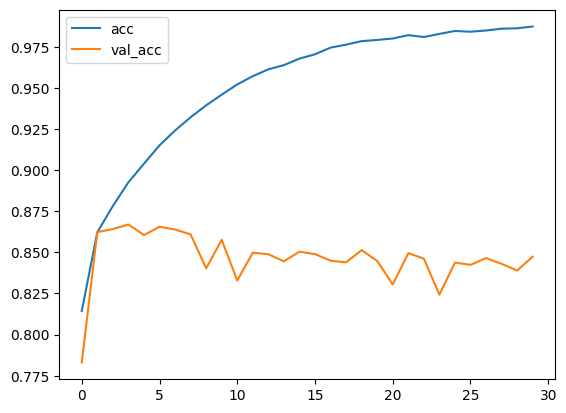

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def ConfusionMatrix(y_pred, Y_test):
    # Compute the Confusion matrix
    cf_matrix = confusion_matrix(Y_test, y_pred)

    # Define categories and group names
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    # Calculate group percentages
    total = np.sum(cf_matrix)
    group_percentages = [f'{cf_matrix[i, j] / total:.2%}' for i in range(cf_matrix.shape[0]) for j in range(cf_matrix.shape[1])]

    # Create labels
    labels = np.asarray(group_names).reshape(2, 2)

    # Plot the Confusion matrix
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()


938/938 [==============================] - 2s 2ms/step
Test accuracy_CNN: 0.8378666666666666
Confusion Matrix: CNN


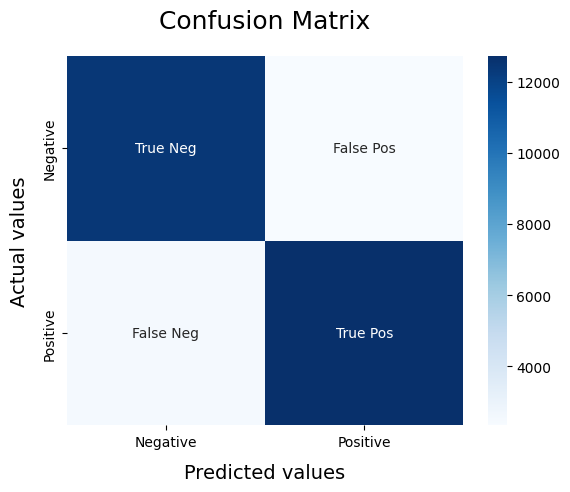

In [ ]:
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Evaluate accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f"Test accuracy_CNN: {accuracy}")

### LSTM model

In [ ]:
#Sentiment analysis using LSTM
from tensorflow.keras.layers import GlobalMaxPool1D
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation="sigmoid")(x)


model_LSTM = Model(input_, output)
model_LSTM.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

In [ ]:
print('Training LSTM model for sentiment analysis...')
r_LSTM = model_LSTM.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training LSTM model for sentiment analysis...
Epoch 1/30
3000/3000 [==============================] - 35s 11ms/step - loss: 0.3779 - accuracy: 0.8309 - val_loss: 0.3434 - val_accuracy: 0.8560
Epoch 2/30
3000/3000 [==============================] - 33s 11ms/step - loss: 0.3247 - accuracy: 0.8605 - val_loss: 0.3175 - val_accuracy: 0.8648
Epoch 3/30
3000/3000 [==============================] - 33s 11ms/step - loss: 0.3100 - accuracy: 0.8673 - val_loss: 0.3225 - val_accuracy: 0.8585
Epoch 4/30
3000/3000 [==============================] - 33s 11ms/step - loss: 0.3001 - accuracy: 0.8716 - val_loss: 0.3016 - val_accuracy: 0.8714
Epoch 5/30
3000/3000 [==============================] - 33s 11ms/step - loss: 0.2915 - accuracy: 0.8753 - val_loss: 0.2962 - val_accuracy: 0.8740
Epoch 6/30
3000/3000 [==============================] - 33s 11ms/step - loss: 0.2923 - accuracy: 0.8756 - val_loss: 0.3180 - val_accuracy: 0.8657
Epoch 7/30
3000/3000 [==============================] - 33s 11ms/step - loss: 

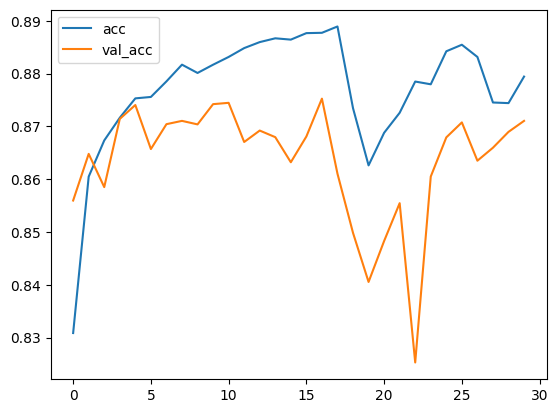

In [ ]:
plt.plot(r_LSTM.history['accuracy'], label='acc')
plt.plot(r_LSTM.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

938/938 [==============================] - 4s 4ms/step
Test accuracy_LSTM: 0.8758333333333334
Confusion Matrix: LSTM model


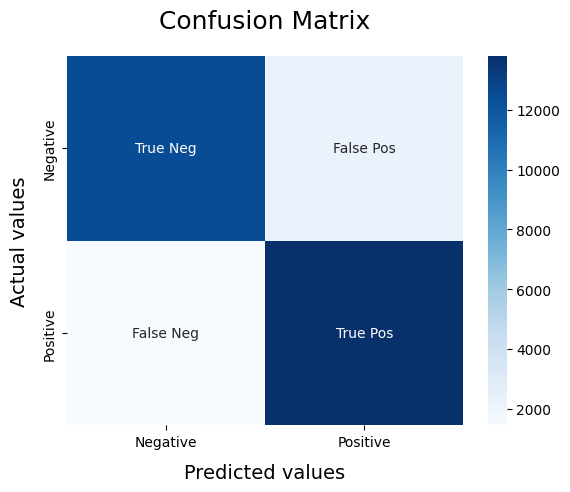

In [ ]:
# Predicting on the Test dataset.
y_pred_lstm = model_LSTM.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred_lstm = np.where(y_pred_lstm >=0.5, 1, 0)

# Evaluate accuracy
accuracy_lstm = accuracy_score(Y_test, y_pred_lstm)
print(f"Test accuracy_LSTM: {accuracy_lstm}")

# Printing out the Evaluation metrics.
print ("Confusion Matrix: LSTM model")
ConfusionMatrix(y_pred_lstm, Y_test)

###Sentiment analysis using bidirectonal RNN

In [ ]:
# create an LSTM network with a single LSTM but with birectional model
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
#x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model_bi = Model(input_, output)
model_bi.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

In [ ]:
print('Training birectional_LSTM model for sentiment analysis...')
r_Bi_LSTM = model_bi.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training birectional_LSTM model for sentiment analysis...
Epoch 1/30
3000/3000 [==============================] - 34s 10ms/step - loss: 0.3425 - accuracy: 0.8486 - val_loss: 0.3152 - val_accuracy: 0.8658
Epoch 2/30
3000/3000 [==============================] - 31s 10ms/step - loss: 0.3045 - accuracy: 0.8679 - val_loss: 0.3036 - val_accuracy: 0.8700
Epoch 3/30
3000/3000 [==============================] - 31s 10ms/step - loss: 0.2895 - accuracy: 0.8765 - val_loss: 0.2994 - val_accuracy: 0.8724
Epoch 4/30
3000/3000 [==============================] - 31s 10ms/step - loss: 0.2813 - accuracy: 0.8807 - val_loss: 0.3006 - val_accuracy: 0.8737
Epoch 5/30
3000/3000 [==============================] - 31s 10ms/step - loss: 0.2746 - accuracy: 0.8844 - val_loss: 0.2984 - val_accuracy: 0.8754
Epoch 6/30
3000/3000 [==============================] - 31s 10ms/step - loss: 0.2698 - accuracy: 0.8864 - val_loss: 0.3022 - val_accuracy: 0.8719
Epoch 7/30
3000/3000 [==============================] - 31s 10ms/s

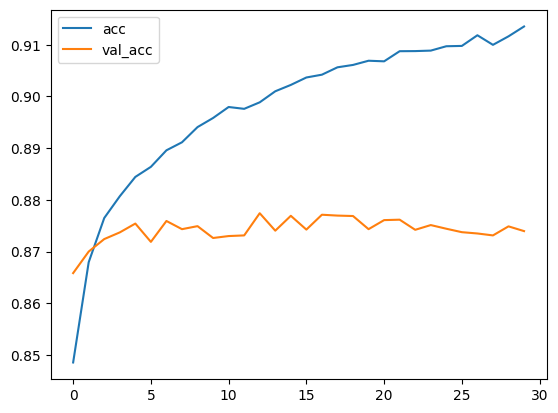

In [ ]:
plt.plot(r_Bi_LSTM.history['accuracy'], label='acc')
plt.plot(r_Bi_LSTM.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

938/938 [==============================] - 5s 4ms/step
Test accuracy_birectional LSTM: 0.8748666666666667
Confusion Matrix: Birectional LSTM model


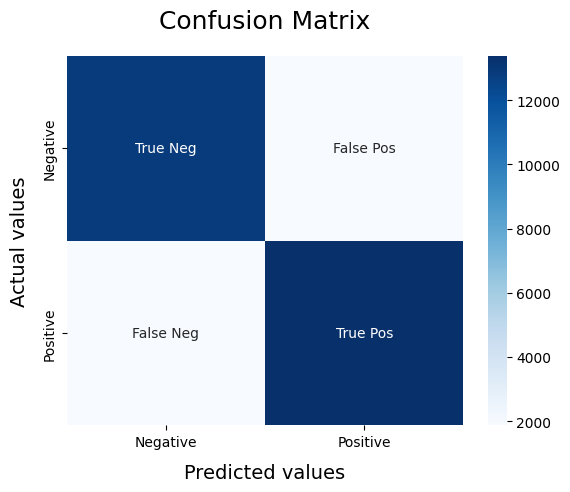

In [ ]:
y_pred_bilstm = model_bi.predict(X_test)
# Converting prediction to reflect the sentiment predicted.
y_pred_bilstm = np.where(y_pred_bilstm >=0.5, 1, 0)

# Evaluate accuracy
accuracy_bilstm = accuracy_score(Y_test, y_pred_bilstm)
print(f"Test accuracy_birectional LSTM: {accuracy_bilstm}")

# Printing out the Evaluation metrics.
print ("Confusion Matrix: Birectional LSTM model")
ConfusionMatrix(y_pred_bilstm, Y_test)

In [ ]:
# Customized Birectional LSTM:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
#x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(100))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_bi_2 = Model(input_, output, name="Sentiment_Model_BiLSTM_version_2" )
model_bi_2.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

In [ ]:
#print('Training birectional_LSTM model version 2 for sentiment analysis...')
r_Bi_LSTM_2 = model_bi_2.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)



Epoch 1/30
3000/3000 [==============================] - 62s 19ms/step - loss: 0.5326 - accuracy: 0.7376 - val_loss: 0.4141 - val_accuracy: 0.8100
Epoch 2/30
3000/3000 [==============================] - 54s 18ms/step - loss: 0.4834 - accuracy: 0.7859 - val_loss: 0.4123 - val_accuracy: 0.8167
Epoch 3/30
3000/3000 [==============================] - 54s 18ms/step - loss: 0.4709 - accuracy: 0.7941 - val_loss: 0.4016 - val_accuracy: 0.8179
Epoch 4/30
3000/3000 [==============================] - 55s 18ms/step - loss: 0.4858 - accuracy: 0.7857 - val_loss: 0.5607 - val_accuracy: 0.6884
Epoch 5/30
3000/3000 [==============================] - 55s 18ms/step - loss: 0.5055 - accuracy: 0.7699 - val_loss: 0.4770 - val_accuracy: 0.7594
Epoch 6/30
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5445 - accuracy: 0.7344 - val_loss: 0.4794 - val_accuracy: 0.7688
Epoch 7/30
3000/3000 [==============================] - 54s 18ms/step - loss: 0.5183 - accuracy: 0.7553 - val_loss: 0.4499 -

In [ ]:
plt.plot(r_Bi_LSTM_2.history['accuracy'], label='acc')
plt.plot(r_Bi_LSTM_2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
y_pred_bilstm_2 = model_bi_2.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred_bilstm_2 = np.where(y_pred_bilstm_2 >=0.5, 1, 0)

# Evaluate accuracy
accuracy_bilstm_2 = accuracy_score(Y_test, y_pred_bilstm_2)
print(f"Test accuracy_birectional LSTM: {accuracy_bilstm_2}")

# Printing out the Evaluation metrics.
print ("Confusion Matrix: Birectional LSTM model version 2")
ConfusionMatrix(y_pred_bilstm_2, Y_test)

### Gru multiplayer and birectional LSTM model :

In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
#x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Bidirectional(GRU(32))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_GRU = Model(input_, output, name="Sentiment_Model_GRU" )
model_GRU.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy'],
)

In [ ]:
r_gru = model_GRU.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

In [ ]:
plt.plot(r_gru).history['accuracy'], label='acc')
plt.plot(r_gru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
